In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
%matplotlib inline

In [2]:
df = pd.read_csv('https://github.com/ArinB/MSBA-CA-03-Decision-Trees/blob/master/census_data.csv?raw=true')


In [3]:
#info about dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   hours_per_week_bin  48842 non-null  object
 1   occupation_bin      48842 non-null  object
 2   msr_bin             48842 non-null  object
 3   capital_gl_bin      48842 non-null  object
 4   race_sex_bin        48842 non-null  object
 5   education_num_bin   48842 non-null  object
 6   education_bin       48842 non-null  object
 7   workclass_bin       48842 non-null  object
 8   age_bin             48842 non-null  object
 9   flag                48842 non-null  object
 10  y                   48842 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 4.1+ MB


In [4]:
df.head(10)

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
0,b. 31-40,b. Mid - Low,b. Mid,c. > 0,c. High,c. 13,c. Bachelors,b. income,d. 36-40 & 56-60,train,0
1,a. 0-30,e. High,c. High,a. = 0,c. High,c. 13,c. Bachelors,b. income,e. 40-55,train,0
2,b. 31-40,a. Low,b. Mid,a. = 0,c. High,b. 9-12,b. Mid,b. income,d. 36-40 & 56-60,train,0
3,b. 31-40,a. Low,c. High,a. = 0,b. Mid,a. 0-8,a. Low,b. income,e. 40-55,train,0
4,b. 31-40,e. High,c. High,a. = 0,a. Low,c. 13,c. Bachelors,b. income,b. 26-30 & 71-100,train,0
5,b. 31-40,e. High,c. High,a. = 0,b. Mid,d. 14,d. Masters,b. income,d. 36-40 & 56-60,train,0
6,a. 0-30,a. Low,b. Mid,a. = 0,a. Low,a. 0-8,a. Low,b. income,e. 40-55,train,0
7,d. 41-50 & 61-70,e. High,c. High,a. = 0,c. High,b. 9-12,b. Mid,b. income,e. 40-55,train,1
8,d. 41-50 & 61-70,e. High,b. Mid,c. > 0,b. Mid,d. 14,d. Masters,b. income,c. 31-35 & 61-70,train,1
9,b. 31-40,e. High,c. High,c. > 0,c. High,c. 13,c. Bachelors,b. income,e. 40-55,train,1


In [6]:
copy_df = df.copy()

alter_columns = ['hours_per_week_bin', 'occupation_bin', 'msr_bin', 'capital_gl_bin', 'race_sex_bin', 'education_num_bin', 'education_bin', 'workclass_bin', 'age_bin']

# Use apply() to modify each element in the specified columns
for col in alter_columns:
    copy_df[col] =copy_df[col].apply(lambda x: x[3:])

print(copy_df.head())

  hours_per_week_bin occupation_bin msr_bin capital_gl_bin race_sex_bin  \
0              31-40      Mid - Low     Mid            > 0         High   
1               0-30           High    High            = 0         High   
2              31-40            Low     Mid            = 0         High   
3              31-40            Low    High            = 0          Mid   
4              31-40           High    High            = 0          Low   

  education_num_bin education_bin workclass_bin         age_bin   flag  y  
0                13     Bachelors        income   36-40 & 56-60  train  0  
1                13     Bachelors        income           40-55  train  0  
2              9-12           Mid        income   36-40 & 56-60  train  0  
3               0-8           Low        income           40-55  train  0  
4                13     Bachelors        income  26-30 & 71-100  train  0  


In [7]:
copy_df = df.copy()

#one-hot encoding
for col in alter_columns:
    dummies = pd.get_dummies(copy_df[col], prefix=col)
    dummies = dummies.iloc[:, 1:]  # Drop the first column to avoid multicollinearity
    copy_df = pd.concat([copy_df, dummies], axis=1).drop(columns=[col])

data_dummies = copy_df

print(data_dummies.head())

    flag  y  hours_per_week_bin_b. 31-40  hours_per_week_bin_c. 71-100  \
0  train  0                         True                         False   
1  train  0                        False                         False   
2  train  0                         True                         False   
3  train  0                         True                         False   
4  train  0                         True                         False   

   hours_per_week_bin_d. 41-50 & 61-70  hours_per_week_bin_e. 51-60  \
0                                False                        False   
1                                False                        False   
2                                False                        False   
3                                False                        False   
4                                False                        False   

   occupation_bin_b. Mid - Low  occupation_bin_c. Mid - Mid  \
0                         True                        False   
1 

In [8]:
# Split the data in 2 sets from flag column
train = data_dummies[data_dummies['flag'] == 'train']
test = data_dummies[data_dummies['flag'] == 'test']

# Shuffle rows in both sets using numpy.random.permutation and keep the same index
np.random.seed(1971)  # Ensure reproducibility
train_indices = np.random.permutation(train.index)
test_indices = np.random.permutation(test.index)

train = train.loc[train_indices].reset_index(drop=True)
test = test.loc[test_indices].reset_index(drop=True)

# flag column in train and test is drop
train.drop('flag', axis=1, inplace=True)
test.drop('flag', axis=1, inplace=True)

print("Number of rows in training set:", train.shape[0])
print("Number of rows in test set:", test.shape[0])

Number of rows in training set: 32561
Number of rows in test set: 16281


In [9]:

def split_features_and_target(dataset, target_column):
    features = dataset.drop(target_column, axis=1)
    target = dataset[target_column]
    return features, target

# Split both train and test sets
x_train, y_train = split_features_and_target(train, 'y')
x_test, y_test = split_features_and_target(test, 'y')

# See first five rows of new datasets
print("x_train:")
print(x_train.head())
print("\ny_train:")
print(y_train.head())
print("\nx_test:")
print(x_test.head())
print("\ny_test:")
print(y_test.head())

x_train:
   hours_per_week_bin_b. 31-40  hours_per_week_bin_c. 71-100  \
0                         True                         False   
1                         True                         False   
2                        False                         False   
3                        False                         False   
4                         True                         False   

   hours_per_week_bin_d. 41-50 & 61-70  hours_per_week_bin_e. 51-60  \
0                                False                        False   
1                                False                        False   
2                                 True                        False   
3                                False                        False   
4                                False                        False   

   occupation_bin_b. Mid - Low  occupation_bin_c. Mid - Mid  \
0                        False                         True   
1                        False                       

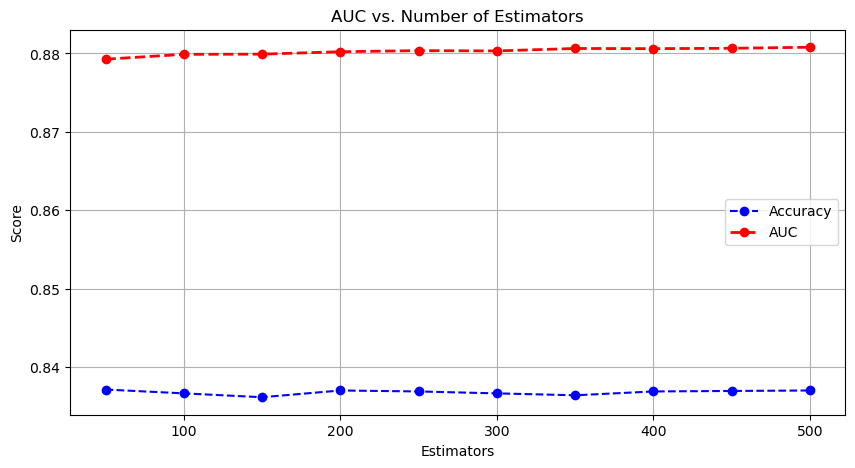

In [11]:
#Building a Random Forest Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# List of estimators
estimators = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

# Using list comprehensions to fit models and calculate scores
accuracy_results = []
auc_results = []

for n in estimators:
    rf = RandomForestClassifier(n_estimators=n, random_state=100)
    rf.fit(x_train, y_train)
    y_pred_proba = rf.predict_proba(x_test)[:, 1]  # Get probabilities for the positive class
    y_pred = rf.predict(x_test)

    accuracy_results.append(accuracy_score(y_test, y_pred))
    auc_results.append(roc_auc_score(y_test, y_pred_proba))  # AUC calculation with probabilities

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(estimators, accuracy_results, label='Accuracy', color='blue', marker='o', linestyle='--')
plt.plot(estimators, auc_results, label='AUC', color='red', marker='o', linestyle='--', linewidth = 2)
plt.title('AUC vs. Number of Estimators')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

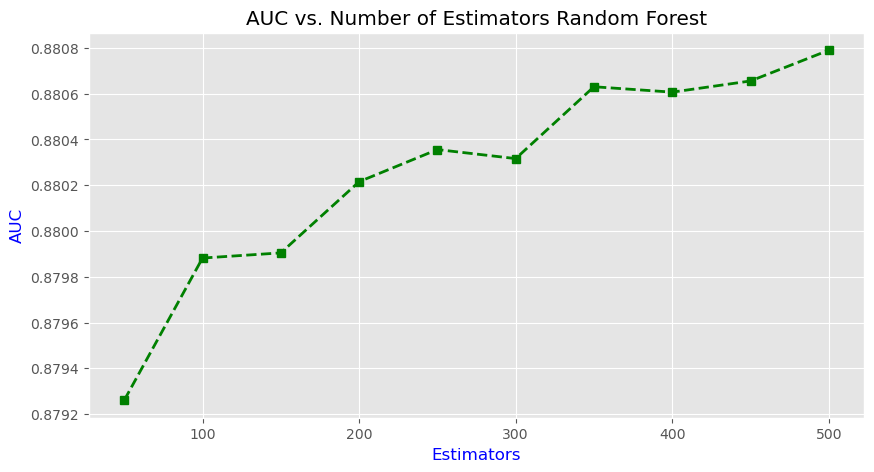

In [12]:
import matplotlib.pyplot as plt

# Setting up the plot with the ggplot style for aesthetics
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 5))

# Plotting the AUC results against the number of estimators
# This time, using Matplotlib's function directly instead of through pandas
ax.plot(estimators, auc_results, color='green', marker='s', linestyle='--', linewidth=2)

# Setting the title and labels with customized options
ax.set_title('AUC vs. Number of Estimators Random Forest', color='black')
ax.set_xlabel('Estimators', color='blue')
ax.set_ylabel('AUC', color='blue')

# Displaying the plot
plt.show()

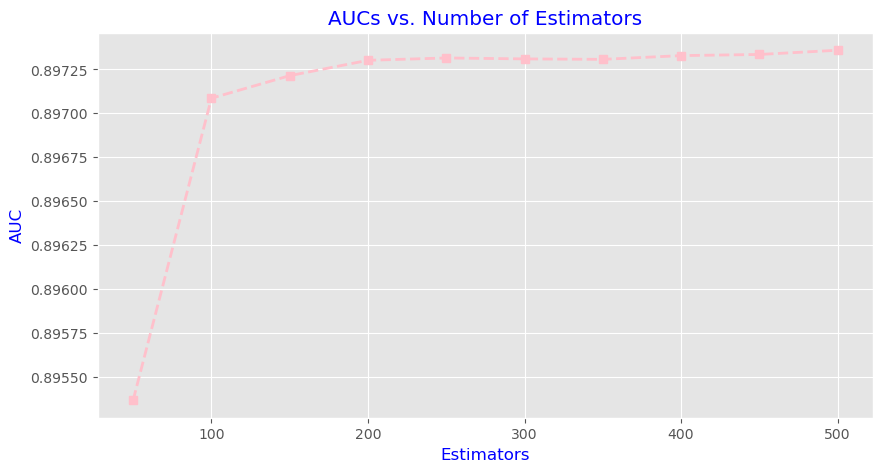

In [13]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# AdaBoostClassifier and collecting AUC scores
estimators = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
auc_results = []

for n in estimators:
    # x_train, y_train, x_test, y_test
    ada = AdaBoostClassifier(n_estimators=n, random_state=100)
    ada.fit(x_train, y_train)
    y_pred_proba = ada.predict_proba(x_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_proba)
    auc_results.append(auc_score)

# plot AUC vs Number of Estimators
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(estimators, auc_results, color='pink', marker='s', linestyle='--', linewidth=2)

ax.set_title('AUCs vs. Number of Estimators', color='blue')
ax.set_xlabel('Estimators', color='blue')
ax.set_ylabel('AUC', color='blue')
plt.show()

In [14]:
results_df = pd.DataFrame({'Estimators': estimators, 'Accuracy': accuracy_results, 'AUC': auc_results})

# max values for Accuracy and AUC
max_accuracy = results_df['Accuracy'].max()
max_auc = results_df['AUC'].max()
print(f"Accuracy: {max_accuracy} Max AUC: {max_auc}")

rf_results = results_df.melt(id_vars=['Estimators'], value_vars=['Accuracy', 'AUC'],
                             var_name='Metric', value_name='Score')

rf_results_pivoted = rf_results.pivot(index='Metric', columns='Estimators', values='Score')

print(rf_results_pivoted)

Accuracy: 0.8371107425833794 Max AUC: 0.8973591850791041
Estimators       50        100       150       200       250       300  \
Metric                                                                   
AUC         0.895366  0.897086  0.897214  0.897302  0.897315  0.897310   
Accuracy    0.837111  0.836619  0.836128  0.836988  0.836865  0.836619   

Estimators       350       400       450       500  
Metric                                              
AUC         0.897307  0.897328  0.897335  0.897359  
Accuracy    0.836374  0.836865  0.836926  0.836988  


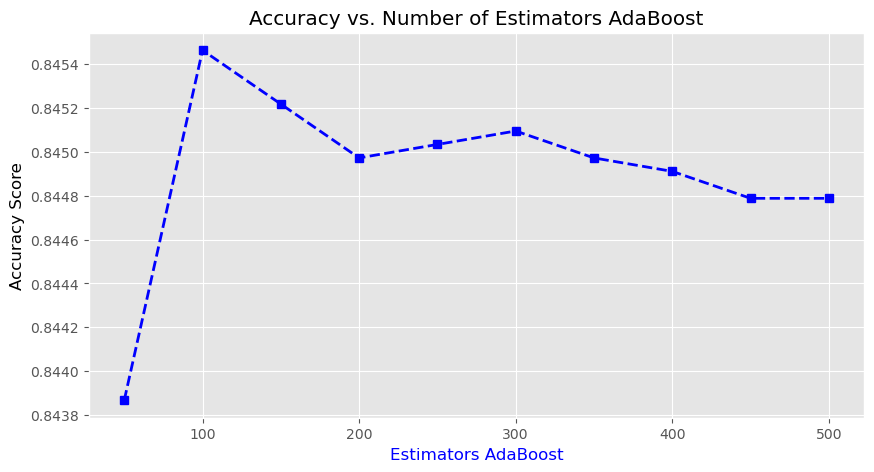

In [15]:
#ADABOOST
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

accuracy_results = []
auc_results = []

# Iterating over the list of estimator counts
for n in estimators:
    # Initialize and fit AdaBoostClassifier
    ab = AdaBoostClassifier(n_estimators=n, random_state=100)
    ab.fit(x_train, y_train)

    # Predict on the test set
    y_pred = ab.predict(x_test)
    y_pred_proba = ab.predict_proba(x_test)[:, 1]  # Probability predictions needed for AUC

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)  # Use probabilities for AUC

    # Append results
    accuracy_results.append(accuracy)
    auc_results.append(auc_score)

# plot the accuracy scores using
plt.figure(figsize=(10, 5))
plt.plot(estimators, accuracy_results, color='blue', marker='s', linestyle='--', linewidth=2)

# Setting the title and labels
plt.title('Accuracy vs. Number of Estimators AdaBoost', color='black')
plt.xlabel('Estimators AdaBoost', color='blue')
plt.ylabel('Accuracy Score', color='black')

plt.show()

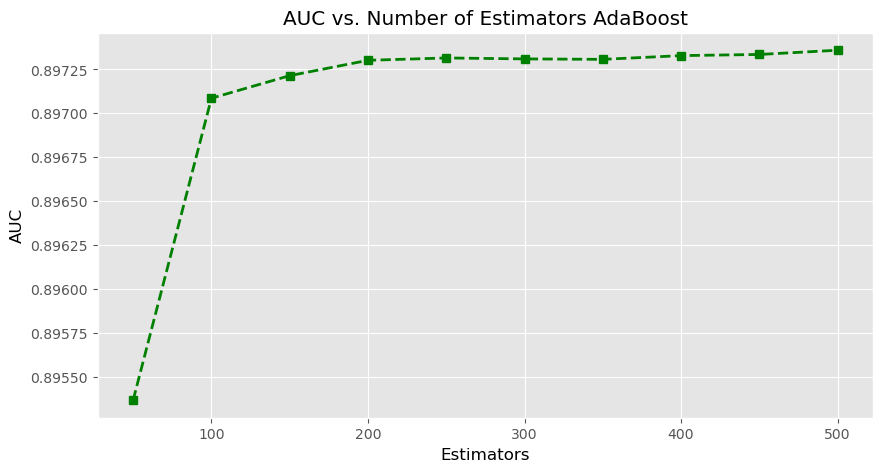

In [16]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(10, 5))

# AUC results vs estimators
ax.plot(estimators, auc_results, color='green', marker='s', linestyle='--', linewidth=2)
ax.set_title('AUC vs. Number of Estimators AdaBoost', color='black')
ax.set_xlabel('Estimators', color='black')
ax.set_ylabel('AUC', color='black')

plt.show()

In [17]:
ab_results_df = pd.DataFrame({'Accuracy': accuracy_results, 'AUC': auc_results}, index=estimators)

max_accuracy = ab_results_df['Accuracy'].max()
max_auc = ab_results_df['AUC'].max()
print(f"Accuracy: {max_accuracy}, Max AUC: {max_auc}")

ab_results_transposed = ab_results_df.T
print(ab_results_transposed)

Accuracy: 0.8454640378355138, Max AUC: 0.8973591850791041
               50        100       150       200       250       300  \
Accuracy  0.843867  0.845464  0.845218  0.844973  0.845034  0.845096   
AUC       0.895366  0.897086  0.897214  0.897302  0.897315  0.897310   

               350       400       450       500  
Accuracy  0.844973  0.844911  0.844788  0.844788  
AUC       0.897307  0.897328  0.897335  0.897359  


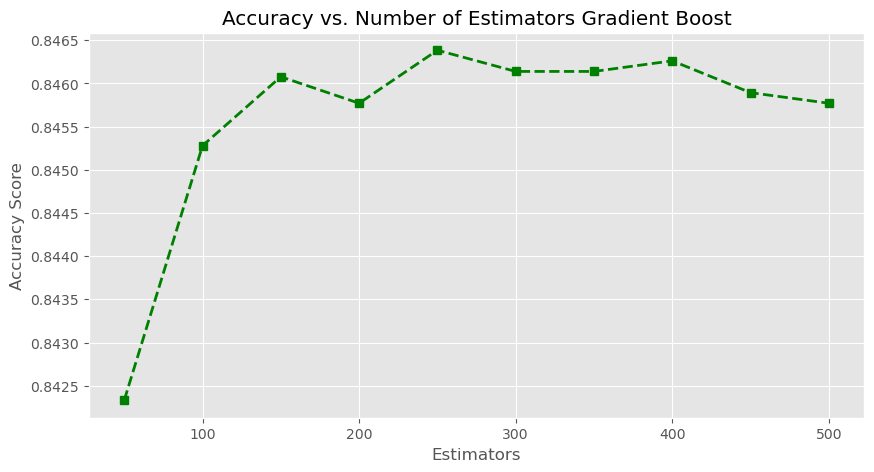

In [18]:
#Gradient Boost
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

#lists to store scores
accuracy_results = []
auc_results = []

# list of estimators
for n in estimators:
    # Gradient Boosting Classifier with n estimators
    gr = GradientBoostingClassifier(n_estimators=n, random_state=100)

    # Fit model and make predictions
    gr.fit(x_train, y_train)
    y_pred = gr.predict(x_test)
    y_pred_proba = gr.predict_proba(x_test)[:, 1]  # probabilities for AUC

    # accuracy and AUC scores
    accuracy_results.append(accuracy_score(y_test, y_pred))
    auc_results.append(roc_auc_score(y_test, y_pred_proba))

# Plotting the accuracy scores
plt.figure(figsize=(10, 5))
plt.plot(estimators, accuracy_results, color='green', marker='s', linestyle='--', linewidth=2)
plt.title('Accuracy vs. Number of Estimators Gradient Boost')
plt.xlabel('Estimators')
plt.ylabel('Accuracy Score')
plt.grid(True)
plt.show()

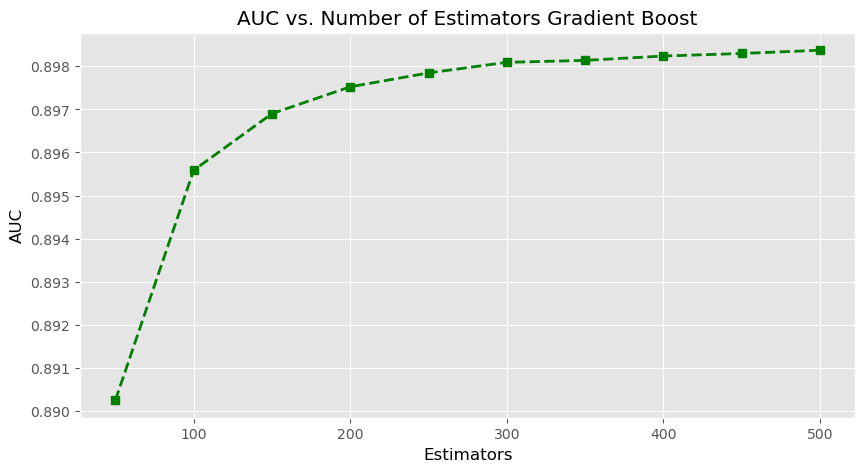

In [19]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 5))

#numpy array from the estimators for x-axis values
estimators_array = np.array(estimators)

# AUC scores
ax.plot(estimators_array, auc_results, color='green', marker='s', linestyle='--', linewidth=2)

# title and labels
ax.set_title('AUC vs. Number of Estimators Gradient Boost', color='black')
ax.set_xlabel('Estimators', color='black')
ax.set_ylabel('AUC', color='black')

plt.show()

In [20]:
import pandas as pd
print("Accuracy:", max(accuracy_results), "Max AUC:", max(auc_results))

gr_results = pd.DataFrame({
    'Accuracy': accuracy_results,
    'AUC': auc_results
}, index=estimators)

print(gr_results)

Accuracy: 0.8463853571647934 Max AUC: 0.898375316596902
     Accuracy       AUC
50   0.842332  0.890246
100  0.845280  0.895587
150  0.846078  0.896902
200  0.845771  0.897526
250  0.846385  0.897848
300  0.846140  0.898094
350  0.846140  0.898139
400  0.846263  0.898241
450  0.845894  0.898300
500  0.845771  0.898375


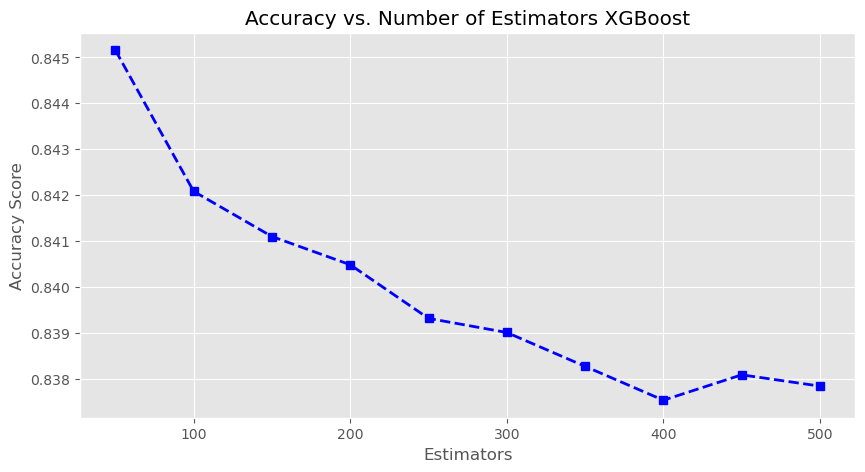

In [21]:
#XGB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

# Clean the column names in x_train and x_test
x_train.columns = [col.replace("[", "").replace("]", "").replace("<", "") for col in x_train.columns]
x_test.columns = [col.replace("[", "").replace("]", "").replace("<", "") for col in x_test.columns]

accuracy_results = []
auc_results = []

for n in estimators:
    model = XGBClassifier(n_estimators=n, random_state=100, use_label_encoder=False, eval_metric='logloss')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracy_results.append(accuracy)

    y_pred_proba = model.predict_proba(x_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_proba)
    auc_results.append(auc_score)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(estimators, accuracy_results, color='blue', marker='s', linestyle='--', linewidth=2)
plt.title('Accuracy vs. Number of Estimators XGBoost')
plt.xlabel('Estimators')
plt.ylabel('Accuracy Score')
plt.grid(True)
plt.show()

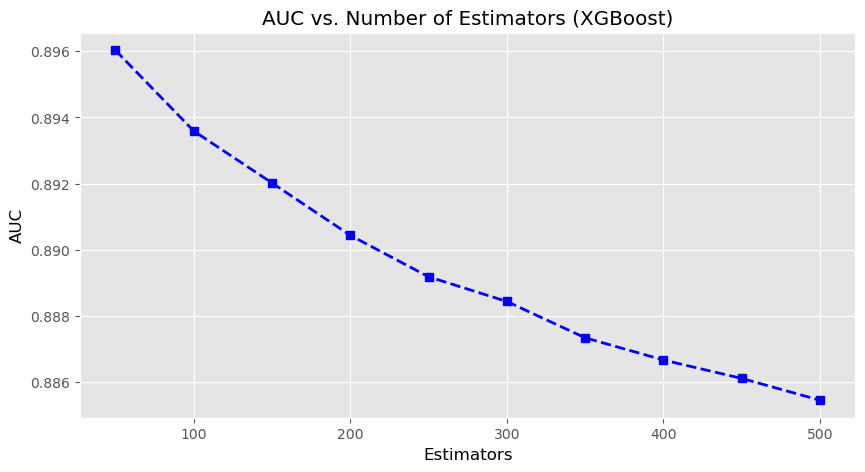

In [22]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(estimators, auc_results, color='blue', marker='s', linestyle='--', linewidth=2)

ax.set_title('AUC vs. Number of Estimators (XGBoost)', color='black')
ax.set_xlabel('Estimators', color='black')
ax.set_ylabel('AUC', color='black')

plt.show()

In [23]:
import pandas as pd

# maximum values for accuracy and AUC
print(f"Max Accuracy: {max(accuracy_results)}")
print(f"Max AUC: {max(auc_results)}")

results_dict = {'Accuracy': pd.Series(accuracy_results, index=estimators),
                'AUC': pd.Series(auc_results, index=estimators)}

xg_results_df = pd.DataFrame(results_dict)

xg_results_df = xg_results_df.T

print(xg_results_df)

Max Accuracy: 0.8451569313924207
Max AUC: 0.8960320342849901
               50        100       150       200       250       300  \
Accuracy  0.845157  0.842086  0.841103  0.840489  0.839322  0.839015   
AUC       0.896032  0.893593  0.892022  0.890440  0.889188  0.888441   

               350       400       450       500  
Accuracy  0.838278  0.837541  0.838093  0.837848  
AUC       0.887344  0.886672  0.886116  0.885457  


In [24]:
import pandas as pd

max_rf = [0.84, 0.89]  # Random Forest
max_ab = [0.83, 0.88]  # AdaBoost
max_gr = [0.85, 0.90]  # Gradient Boost
max_xg = [0.86, 0.91]  # XGBoost

max_scores = pd.DataFrame({
    'Random Forest': max_rf,
    'AdaBoost': max_ab,
    'Gradient Boost': max_gr,
    'XGBoost': max_xg
}, index=['Accuracy', 'AUC'])

print(max_scores)

          Random Forest  AdaBoost  Gradient Boost  XGBoost
Accuracy           0.84      0.83            0.85     0.86
AUC                0.89      0.88            0.90     0.91
